In [54]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm as norm
import scipy as sp
import scipy.stats

In [67]:
def compute_margin_estimate():
    m = 0.0
    for i in range(20):
        A = np.random.normal([-2,-2], np.sqrt(0.5), [10000,2])
        B = np.random.normal([-10,-10], np.sqrt(0.25), [10000,2])
        p1 = np.array([-6,0])
        p2 = np.array([0,-6])
        min_d1 = 10
        for p3 in A:
            d = norm(np.cross(p2-p1, p1-p3))/norm(p2-p1)
            min_d1 = min(min_d1,d)

        min_d2 = 10
        for p3 in B:
            d = norm(np.cross(p2-p1, p1-p3))/norm(p2-p1)
            min_d2 = min(min_d2,d)
        m+= min_d1+min_d2
    return m/40

In [68]:
compute_margin_estimate()

3.948706121386538

In [76]:
def compute_estimated_max_norm():
    m = 0.0
    for i in range(20):
        B = np.random.normal([-10,-10], np.sqrt(0.25), [10000,2])
        B = np.c_[B,np.ones_like(B[:,0])]
        max_norm = 0
        for b in B:
            max_norm = max(max_norm,norm(b))
        m+= max_norm
    return m/20

In [77]:
compute_estimated_max_norm()

16.04795865801423

In [22]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * sp.stats.t._ppf((1+confidence)/2., n-1)
    return m, m-h, m+h

In [2]:
def perceptron(X,Y,eta=0.5,metric=False):
    if metric:
        delta = []
        I = []
        mistakes = 0
    
    i = 0
    w = np.zeros_like(X[0,:])
    for x,y in zip(X,Y):
        y_classifier = np.sign(np.sum(w*x))
        l = y - y_classifier
        w_new = w + eta*l*x
        if(metric and norm(w)>0):
            delta.append(norm(w_new/norm(w_new) - w/(norm(w))))
            I.append(i)
        if(metric and l!=0):
            mistakes = mistakes+1
        w = w_new
        i+=1
    if metric:
        return w, delta, I, mistakes
    else:
        return w

def winnow(X,Y, eta=0.001, metric=False):
    if metric:
        delta = []
        I = []
        mistakes = 0
        
    
    i = 0
    w = np.ones_like(X[0,:])
    w = w/np.sum(w)
    
    for x,y in zip(X,Y):
        l = y - np.sign(np.sum(w*x))
        if l != 0:
            w_new = w*np.exp(eta*x*y)
            w_new = w_new/np.sum(w_new)
            if(metric):
                mistakes = mistakes+1
            
            if(metric and norm(w)>0):
                delta.append(norm(w_new/norm(w_new) - w/(norm(w))))
                I.append(i)
            w = w_new
        i+=1
    
    if metric:
        return w, delta, I, mistakes
    else:
        return w

In [3]:
def prep_data():
    a = np.random.normal([-2,-2], np.sqrt(0.5), [10000,2])
    b = np.random.normal([-10,-10], np.sqrt(0.25), [10000,2])
    d1 = np.vstack([a[:,0],a[:,1],np.ones_like(a[:,0]),np.ones_like(a[:,0])]).T
    d2 = np.vstack([b[:,0],b[:,1],np.ones_like(b[:,0]),-1*np.ones_like(b[:,0])]).T
    d = np.append(d1,d2,0)

    np.random.shuffle(d)
    X = d[:,:-1]
    Y = d[:,-1]

    #Adding the bias term
    #X = np.c_[X, np.ones_like(X[:,0])]

    plus = np.where(Y==1)[0]
    minus = np.where(Y==-1)[0]
    return X, Y, plus, minus

In [7]:
def generate_results(eta_w = 0.001):
    
    X,Y, plus, minus = prep_data()
    w, delta, I, mistakes_p = perceptron(X,Y, metric = True)
    
    mc_p = np.sum(abs(Y-np.sign(np.sum(w*X,1))))/2
    
    w_w, delta_w, I_w, mistakes_w = winnow(X,Y, eta=eta_w, metric = True)
    
    mc_w = np.sum(abs(Y-np.sign(np.sum(w_w*X,1))))/2
    n = Y.size
    
    perc_error = "Error for Perceptron: \n \t Mistakes: {1}/{3} = {4:3.2f}% \n \t Misclassification by final model: {2:.0f}/{3} = {5:3.2f}%".format(0,mistakes_p,mc_p,n,mistakes_p*100.0/n,mc_p*100.0/n)
    winnow_error = "Error for Winnow: \n \t Mistakes: {1}/{3} = {4:3.2f}% \n \t Misclassification by final model: {2:.0f}/{3} = {5:3.2f}%".format(0,mistakes_w,mc_w,n,mistakes_w*100.0/n,mc_w*100.0/n)
    
    fig, axs = plt.subplots(1,2, figsize=(20,8))
    
    axs[0].set_title("Perceptron", fontsize=24)
    axs[1].set_title("Winnow with $\eta = {:.2f}$".format(eta_w), fontsize=24)
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    axs[0].text(0.13, 0.97, perc_error, transform=axs[0].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    axs[1].text(0.13, 0.97, winnow_error, transform=axs[1].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    
    for ax, wi in zip(axs, [w,w_w]):
        ax.plot(X[plus,0], X[plus,1], 'b.')
        ax.plot(X[minus,0], X[minus,1], 'r.')
        #ax.set_ylabel("Norm of change in direction of seperating plane", fontsize=20)
        #ax.set_xlabel("$t$", fontsize=20)
        x = np.linspace(-12,1,100)
        y =  (-wi[2]-wi[0]*x)/wi[1]
        ax.plot(x,y);
        ax.set_xlim([-12,3])
        ax.set_ylim([-12,3])
    
    plt.savefig("q6a.png")
    plt.show()

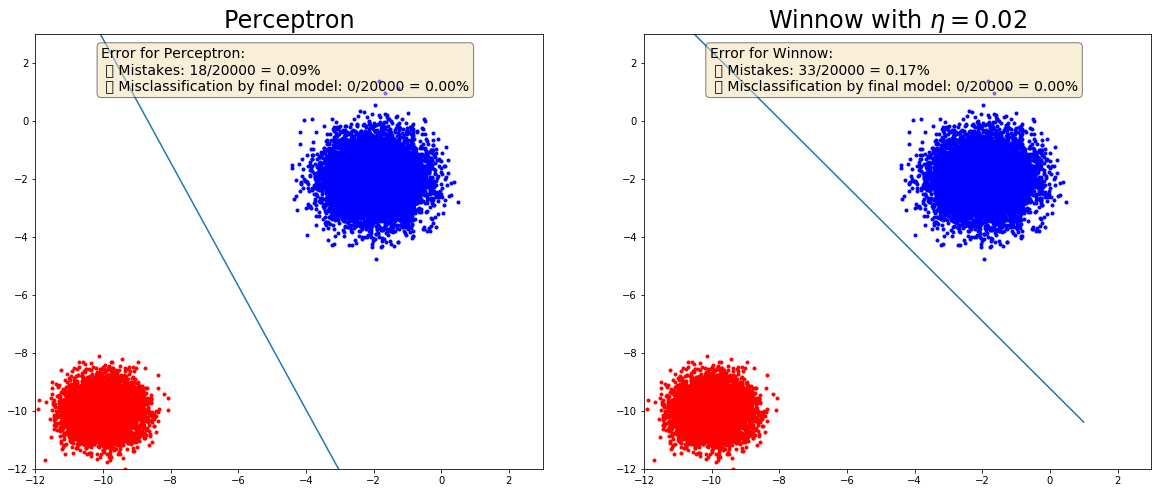

In [82]:
generate_results(eta_w=2e-2)

In [39]:
def winnow_results():
    Eta = np.linspace(1e-2,5e-1,20)
    num_mistakes = []
    for eta_w in Eta: 
        m = []
        for count in range(10):
            X,Y, plus, minus = prep_data()
            w_w, delta_w, I_w, mistakes_w = winnow(X,Y, eta=eta_w, metric = True)
            m.append(mistakes_w)
        num_mistakes.append(m)
    return Eta, num_mistakes

In [40]:
Eta, num_mistakes = winnow_results()

In [41]:
mistakes = np.array(num_mistakes).T
mean_m = np.ones_like(mistakes[0])
upper_m = np.ones_like(mistakes[0])
lower_m = np.ones_like(mistakes[0])
for i,m in enumerate(mistakes.T):
    mean_m[i], lower_m[i], upper_m[i] = mean_confidence_interval(m)

In [42]:
def plot(ax,x,y,yu,yl):
    ax.plot(x,y,'b-x')
    ax.plot(x,yu,'r', alpha=0.3)
    ax.plot(x,yl,'r', alpha=0.3)
    ax.fill_between(x,y,yu, facecolor='red', alpha='0.2')
    ax.fill_between(x,yl,y, facecolor='red', alpha='0.2')
    ax.set_ylabel("Number of mistakes", fontsize=20)
    ax.set_xlabel("$t$", fontsize=20)

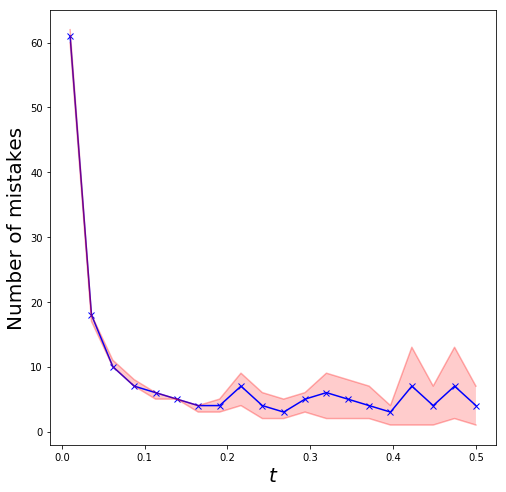

In [44]:
fig, ax = plt.subplots(figsize = (8,8))
plot(ax,Eta,mean_m,upper_m,lower_m)
plt.savefig("q6b.pdf")
plt.show()